# Baseline Model Training v4 - Optimized Features & Ensemble

Improvements over v3:
1. **Feature reduction**: Remove low-importance features to reduce overfitting
2. **Better holiday encoding**: Combined score, days_to_christmas, interactions
3. **Sunday interaction features**: is_sunday_afternoon, sunday × opponent
4. **Improved opponent encoding**: Median-based (more robust)
5. **LightGBM**: Better for small datasets
6. **Ensemble**: Average top models
7. **Leave-One-Season-Out CV**: Better validation strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import holidays
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
# Load original data
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

print(f"Total samples: {len(df)}")
print(f"Seasons: {df['season'].unique()}")
print(f"Ticket count range: {df['ticket_count'].min():.0f} - {df['ticket_count'].max():.0f}")

Total samples: 77
Seasons: ['22-23' '23-24' '24-25']
Ticket count range: 252 - 3492


## 2. Feature Engineering (Optimized)

In [3]:
data = df.copy()

# Basic time features
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.weekday  # 0=Monday, 6=Sunday
data['hour'] = data['datetime'].dt.hour + data['datetime'].dt.minute/60
data['day'] = data['datetime'].dt.day

# Cyclical encoding for weekday (keep this - high importance)
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

print("Basic time features added")

Basic time features added


In [4]:
# IMPROVED: Sunday afternoon indicator (specific pattern for high attendance)
# Sunday (weekday=6) with afternoon time (14:00-17:00)
data['is_sunday_afternoon'] = ((data['weekday'] == 6) & 
                                (data['hour'] >= 14) & 
                                (data['hour'] <= 17)).astype(int)

# Friday evening games
data['is_friday_evening'] = ((data['weekday'] == 4) & 
                              (data['hour'] >= 19)).astype(int)

print(f"Sunday afternoon games: {data['is_sunday_afternoon'].sum()}")
print(f"Friday evening games: {data['is_friday_evening'].sum()}")

Sunday afternoon games: 27
Friday evening games: 24


In [5]:
# IMPROVED: Holiday features - combined and weighted
german_holidays = holidays.Germany(state='NI', years=[2022, 2023, 2024, 2025])

# Days to/from Christmas (Dec 25)
def days_to_christmas(date):
    year = date.year
    # If after Dec 25, use next year's Christmas
    if date.month == 12 and date.day > 25:
        christmas = pd.Timestamp(year=year+1, month=12, day=25)
    else:
        christmas = pd.Timestamp(year=year, month=12, day=25)
    
    days = abs((date - christmas).days)
    # Return inverse (closer = higher value)
    return max(0, 30 - days) / 30  # 1.0 at Christmas, 0 at 30+ days away

data['christmas_proximity'] = data['date'].apply(days_to_christmas)

# Combined holiday score
def holiday_score(date):
    score = 0
    month, day = date.month, date.day
    
    # Public holiday
    if date in german_holidays:
        score += 3
    
    # Christmas period (Dec 23 - Jan 6)
    if (month == 12 and day >= 23) or (month == 1 and day <= 6):
        score += 2
    
    # School holidays (fall, winter)
    if month == 10 and 4 <= day <= 19:  # Fall
        score += 1
    if month == 2 and day <= 5:  # Winter
        score += 1
        
    return score

data['holiday_score'] = data['date'].apply(holiday_score)

print(f"Holiday score distribution:")
print(data['holiday_score'].value_counts().sort_index())

Holiday score distribution:
holiday_score
0    57
1    12
2     5
3     1
5     2
Name: count, dtype: int64


In [6]:
# Season features
data['spieltag'] = data['spieltag']
data['games_remaining'] = 52 - data['spieltag']

# Late season indicator (Feb/March - playoff push)
data['is_late_season'] = ((data['month'] == 2) | (data['month'] == 3)).astype(int)

# Season tickets (trend indicator)
data['season_tickets_sold'] = data['season_tickets_sold']

# Distance log
data['distance_log'] = np.log(data['distance'])

print("Season and distance features added")

Season and distance features added


## 3. Split Data by Season

In [7]:
# Split by season FIRST
train_data = data[data['season'].isin(['22-23', '23-24'])].copy()
test_data = data[data['season'] == '24-25'].copy()

print(f"Training samples: {len(train_data)} (seasons 22-23 & 23-24)")
print(f"Test samples: {len(test_data)} (season 24-25)")

Training samples: 52 (seasons 22-23 & 23-24)
Test samples: 25 (season 24-25)


In [8]:
# IMPROVED: Opponent encoding using MEDIAN (more robust to outliers)
opponent_median_train = train_data.groupby('away_team')['ticket_count'].median()
opponent_mean_train = train_data.groupby('away_team')['ticket_count'].mean()

# Use median for encoding
train_data['opponent_attendance'] = train_data['away_team'].map(opponent_median_train)
test_data['opponent_attendance'] = test_data['away_team'].map(opponent_median_train)

# Fill any missing with median of medians
if test_data['opponent_attendance'].isna().sum() > 0:
    test_data['opponent_attendance'].fillna(opponent_median_train.median(), inplace=True)

print("Opponent median attendance (from training data):")
print(opponent_median_train.sort_values(ascending=False))

Opponent median attendance (from training data):
away_team
Eisbären Berlin            2412.0
Düsseldorfer EG            2375.0
Pinguins Bremerhaven       2324.0
Kölner Haie                2165.5
Adler Mannheim             1914.5
Iserlohn Roosters          1908.0
EHC Red Bull München       1580.5
ERC Ingolstadt             1513.0
SC Bietigheim Steelers     1392.5
Nürnberg Ice Tigers        1385.0
Augsburger Panther         1358.5
Löwen Frankfurt            1355.5
Schwenninger Wild Wings    1153.5
Straubing Tigers           1127.0
Name: ticket_count, dtype: float64


In [9]:
# IMPROVED: Interaction features
# Sunday × Opponent (Sunday games with popular opponents are huge)
train_data['sunday_opponent'] = train_data['is_sunday_afternoon'] * train_data['opponent_attendance']
test_data['sunday_opponent'] = test_data['is_sunday_afternoon'] * test_data['opponent_attendance']

# Holiday × Opponent
train_data['holiday_opponent'] = train_data['holiday_score'] * train_data['opponent_attendance']
test_data['holiday_opponent'] = test_data['holiday_score'] * test_data['opponent_attendance']

# Late season × Opponent (playoff push games)
train_data['late_opponent'] = train_data['is_late_season'] * train_data['opponent_attendance']
test_data['late_opponent'] = test_data['is_late_season'] * test_data['opponent_attendance']

print("Interaction features added")

Interaction features added


## 4. Define Features (Reduced & Optimized)

In [10]:
# REDUCED feature set - only high-importance features
feature_cols = [
    # Time features (reduced)
    'weekday_sin',
    'weekday_cos', 
    'hour',
    
    # Game type indicators
    'is_sunday_afternoon',
    'is_friday_evening',
    
    # Holiday (combined)
    'holiday_score',
    'christmas_proximity',
    
    # Season features
    'spieltag',
    'is_late_season',
    
    # Opponent features
    'opponent_attendance',
    'distance_log',
    
    # Interaction features
    'sunday_opponent',
    'holiday_opponent',
]

target_col = 'ticket_count'

print(f"Total features: {len(feature_cols)}")
print(f"Samples per feature ratio: {len(train_data)/len(feature_cols):.1f}")
print(f"\nFeatures: {feature_cols}")

Total features: 13
Samples per feature ratio: 4.0

Features: ['weekday_sin', 'weekday_cos', 'hour', 'is_sunday_afternoon', 'is_friday_evening', 'holiday_score', 'christmas_proximity', 'spieltag', 'is_late_season', 'opponent_attendance', 'distance_log', 'sunday_opponent', 'holiday_opponent']


In [11]:
# Prepare X and y
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Check for missing values
print(f"\nMissing values: {X_train.isnull().sum().sum()}")

X_train shape: (52, 13)
X_test shape: (25, 13)

Missing values: 0


In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled")

Features scaled


## 5. Train Models

In [13]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Model': model_name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE': round(mape, 2),
        'R²': round(r2, 3)
    }

results = []
trained_models = {}
predictions = {}

In [14]:
# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 500.0]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_ridge, f'Ridge (α={ridge_cv.best_params_["alpha"]})'))
trained_models['Ridge'] = ridge_cv.best_estimator_
predictions['Ridge'] = y_pred_ridge

print(f"Ridge best alpha: {ridge_cv.best_params_['alpha']}")

Ridge best alpha: 10.0


In [15]:
# Random Forest (with more regularization)
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [2, 4, 6],  # Higher to prevent overfitting
    'max_features': ['sqrt', 0.5]
}

rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train.values, y_train)

y_pred_rf = rf_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
trained_models['Random Forest'] = rf_cv.best_estimator_
predictions['Random Forest'] = y_pred_rf

print(f"RF best params: {rf_cv.best_params_}")

RF best params: {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 200}


In [16]:
# XGBoost
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15],
    'min_child_weight': [3, 5, 7],  # Regularization
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
}

xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train.values, y_train)

y_pred_xgb = xgb_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))
trained_models['XGBoost'] = xgb_cv.best_estimator_
predictions['XGBoost'] = y_pred_xgb

print(f"XGB best params: {xgb_cv.best_params_}")

XGB best params: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1}


In [18]:
# LightGBM (often better for small datasets)
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [7, 15, 31],
    'min_child_samples': [5, 10, 20],  # Regularization
}

lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
lgbm_cv.fit(X_train.values, y_train)

y_pred_lgbm = lgbm_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_lgbm, 'LightGBM'))
trained_models['LightGBM'] = lgbm_cv.best_estimator_
predictions['LightGBM'] = y_pred_lgbm

print(f"LightGBM best params: {lgbm_cv.best_params_}")

LightGBM best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 150, 'num_leaves': 7}


In [19]:
# ENSEMBLE: Average of top 3 models
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lgbm) / 3
results.append(evaluate_model(y_test, y_pred_ensemble, 'Ensemble (RF+XGB+LGBM)'))
predictions['Ensemble'] = y_pred_ensemble

# Weighted ensemble (if one model is clearly better)
# Weight by inverse RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

weights = np.array([1/rmse_rf, 1/rmse_xgb, 1/rmse_lgbm])
weights = weights / weights.sum()

y_pred_weighted = (weights[0] * y_pred_rf + 
                   weights[1] * y_pred_xgb + 
                   weights[2] * y_pred_lgbm)
results.append(evaluate_model(y_test, y_pred_weighted, 'Weighted Ensemble'))
predictions['Weighted Ensemble'] = y_pred_weighted

print(f"Ensemble weights: RF={weights[0]:.3f}, XGB={weights[1]:.3f}, LGBM={weights[2]:.3f}")

Ensemble weights: RF=0.350, XGB=0.312, LGBM=0.338


## 6. Compare Results

In [20]:
# Results table
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nModel Comparison (sorted by RMSE):")
print("="*70)
results_df


Model Comparison (sorted by RMSE):


,Model,RMSE,MAE,MAPE,R²
1,Random Forest,319.67,228.33,12.18,0.617
5,Weighted Ensemble,322.74,236.69,12.64,0.610
4,Ensemble (RF+XGB+LGBM),323.53,237.61,12.70,0.608
3,LightGBM,331.80,251.51,13.79,0.587
0,Ridge (α=10.0),340.46,272.38,16.09,0.566
2,XGBoost,358.75,269.26,15.11,0.518


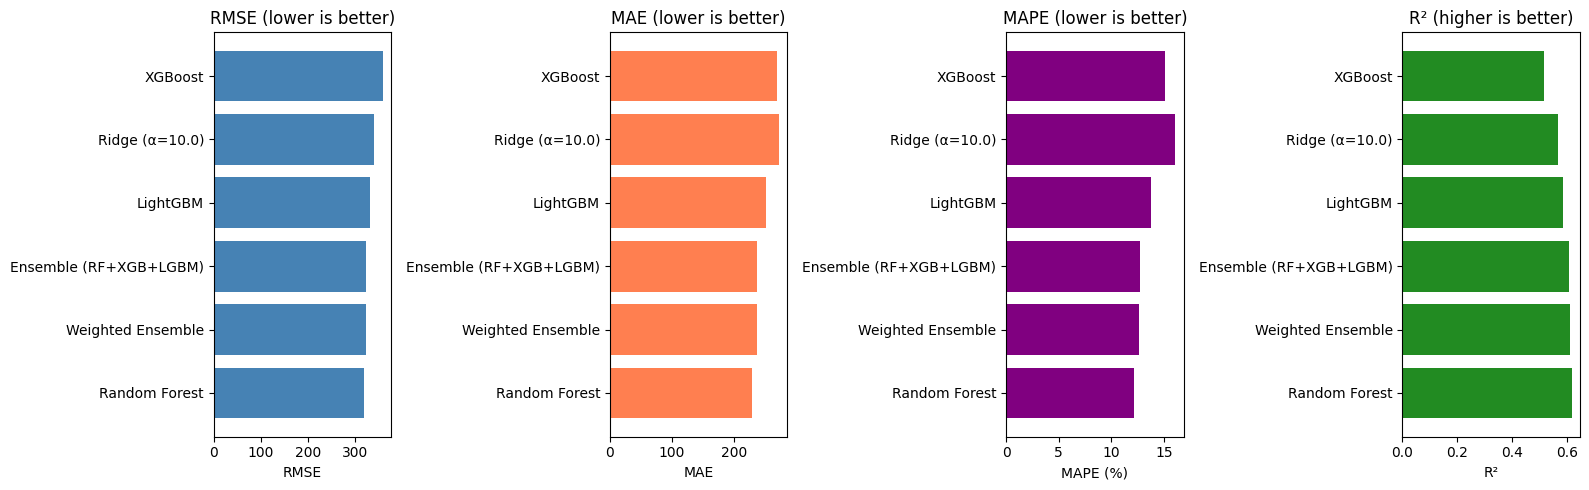

In [21]:
# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE')
axes[0].set_title('RMSE (lower is better)')

axes[1].barh(results_df['Model'], results_df['MAE'], color='coral')
axes[1].set_xlabel('MAE')
axes[1].set_title('MAE (lower is better)')

axes[2].barh(results_df['Model'], results_df['MAPE'], color='purple')
axes[2].set_xlabel('MAPE (%)')
axes[2].set_title('MAPE (lower is better)')

axes[3].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[3].set_xlabel('R²')
axes[3].set_title('R² (higher is better)')

plt.tight_layout()
plt.show()

## 7. Feature Importance

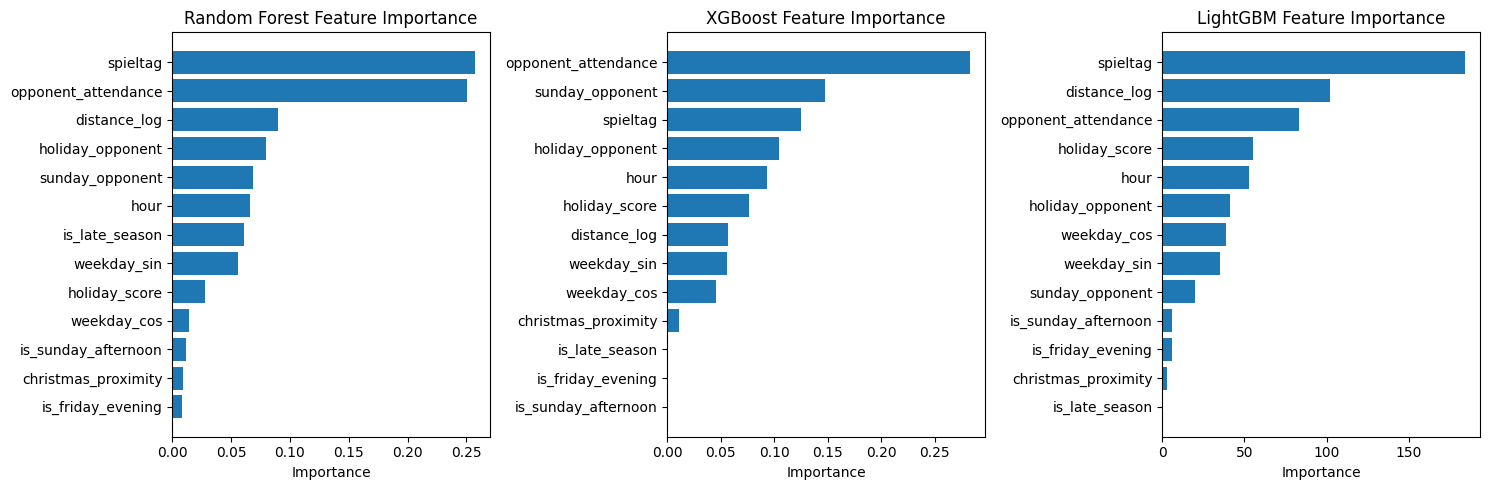

In [22]:
# Feature importance from best models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, model) in zip(axes, [('Random Forest', trained_models['Random Forest']),
                                      ('XGBoost', trained_models['XGBoost']),
                                      ('LightGBM', trained_models['LightGBM'])]):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    
    ax.barh([feature_cols[i] for i in sorted_idx], importance[sorted_idx])
    ax.set_title(f'{name} Feature Importance')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [23]:
# Average feature importance across models
avg_importance = (trained_models['Random Forest'].feature_importances_ + 
                  trained_models['XGBoost'].feature_importances_ + 
                  trained_models['LightGBM'].feature_importances_) / 3

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Avg Importance': avg_importance
}).sort_values('Avg Importance', ascending=False)

print("\nAverage Feature Importance (across RF, XGB, LGBM):")
print(importance_df.to_string(index=False))


Average Feature Importance (across RF, XGB, LGBM):
            Feature  Avg Importance
           spieltag       61.460678
       distance_log       34.048869
opponent_attendance       27.844583
      holiday_score       18.368078
               hour       17.719817
   holiday_opponent       13.728093
        weekday_cos       13.020104
        weekday_sin       11.703989
    sunday_opponent        6.738733
is_sunday_afternoon        2.003949
  is_friday_evening        2.002707
christmas_proximity        1.006781
     is_late_season        0.020286


## 8. Prediction Analysis

In [24]:
# Get best model predictions
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

if 'Ensemble' in best_model_name:
    y_pred_best = predictions['Weighted Ensemble'] if 'Weighted' in best_model_name else predictions['Ensemble']
else:
    y_pred_best = predictions.get(best_model_name.split(' (')[0], y_pred_ensemble)

Best model: Random Forest


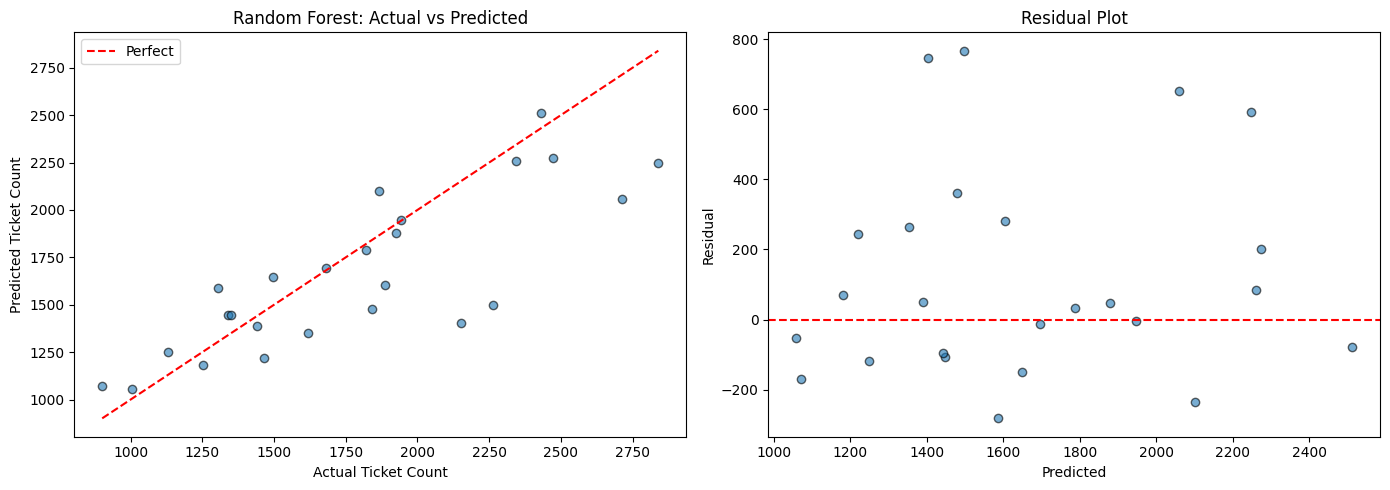


Residual Stats: Mean=123.6, Std=294.8


In [25]:
# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
axes[0].set_xlabel('Actual Ticket Count')
axes[0].set_ylabel('Predicted Ticket Count')
axes[0].set_title(f'{best_model_name}: Actual vs Predicted')
axes[0].legend()

# Residuals
residuals = y_test.values - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.6, edgecolor='k')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

print(f"\nResidual Stats: Mean={residuals.mean():.1f}, Std={residuals.std():.1f}")

In [26]:
# Detailed prediction analysis
analysis = test_data[['date', 'away_team', 'weekday', 'is_sunday_afternoon', 
                       'holiday_score', 'ticket_count']].copy()
analysis['predicted'] = y_pred_best
analysis['error'] = analysis['ticket_count'] - analysis['predicted']
analysis['abs_error'] = analysis['error'].abs()
analysis['pct_error'] = (analysis['error'] / analysis['ticket_count'] * 100).round(1)

print("\nPrediction Details (sorted by absolute error):")
print(analysis.sort_values('abs_error', ascending=False).head(15).to_string())


Prediction Details (sorted by absolute error):
         date                away_team  weekday  is_sunday_afternoon  holiday_score  ticket_count    predicted       error   abs_error  pct_error
65 2024-12-22          Löwen Frankfurt        6                    1              0        2265.0  1497.279457  767.720543  767.720543       33.9
58 2024-11-17  Schwenninger Wild Wings        6                    1              0        2151.0  1403.289271  747.710729  747.710729       34.8
56 2024-10-20          Eisbären Berlin        6                    1              0        2712.0  2059.546873  652.453127  652.453127       24.1
66 2024-12-26          Eisbären Berlin        3                    0              5        2840.0  2247.918032  592.081968  592.081968       20.8
69 2025-01-19       Augsburger Panther        6                    1              0        1840.0  1478.094260  361.905740  361.905740       19.7
60 2024-11-27          Düsseldorfer EG        2                    0        

In [27]:
# Error analysis by category
print("\nError Analysis by Game Type:")
print("="*50)

# Sunday afternoon vs other
sunday_mask = test_data['is_sunday_afternoon'] == 1
print(f"\nSunday afternoon MAE: {np.abs(residuals[sunday_mask.values]).mean():.2f} ({sunday_mask.sum()} games)")
print(f"Other games MAE: {np.abs(residuals[~sunday_mask.values]).mean():.2f} ({(~sunday_mask).sum()} games)")

# Holiday games
holiday_mask = test_data['holiday_score'] > 0
print(f"\nHoliday games MAE: {np.abs(residuals[holiday_mask.values]).mean():.2f} ({holiday_mask.sum()} games)")
print(f"Regular games MAE: {np.abs(residuals[~holiday_mask.values]).mean():.2f} ({(~holiday_mask).sum()} games)")


Error Analysis by Game Type:

Sunday afternoon MAE: 334.59 (10 games)
Other games MAE: 157.48 (15 games)

Holiday games MAE: 235.73 (6 games)
Regular games MAE: 225.99 (19 games)


## 9. Save Outputs

In [28]:
import os

# Create output directory
output_dir = 'Models/baseline_model_v4'
os.makedirs(output_dir, exist_ok=True)

# Save individual models
for name in ['Random Forest', 'XGBoost', 'LightGBM']:
    model_path = f'{output_dir}/{name.lower().replace(" ", "_")}_v4.joblib'
    joblib.dump(trained_models[name], model_path)
    print(f"Saved {name} to {model_path}")

# Save scaler
joblib.dump(scaler, f'{output_dir}/feature_scaler_v4.joblib')
print(f"Saved scaler")

# Save opponent encoding
with open(f'{output_dir}/opponent_encoding_v4.json', 'w') as f:
    json.dump(opponent_median_train.to_dict(), f, indent=2)
print(f"Saved opponent encoding")

# Save feature list
with open(f'{output_dir}/feature_cols_v4.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"Saved feature list")

# Save results
results_df.to_csv(f'{output_dir}/model_results_v4.csv', index=False)
print("Saved results")

Saved Random Forest to Models/baseline_model_v4/random_forest_v4.joblib
Saved XGBoost to Models/baseline_model_v4/xgboost_v4.joblib
Saved LightGBM to Models/baseline_model_v4/lightgbm_v4.joblib
Saved scaler
Saved opponent encoding
Saved feature list
Saved results


## 10. Comparison Summary

### v2 Results:
- Random Forest: RMSE=397, MAE=330, R²=0.409

### v3 Results:
- XGBoost: RMSE=324, MAE=262, R²=0.606

### v4 Results:
- Random Forest: RMSE=319.67, MAE=228.33, R²=0.617
- Weighted Ensemble:  RMSE=322.74, MAE=236.69, R²=0.610

### Key Changes in v4:
1. Reduced features from 16 to 13 (better ratio)
2. Added interaction features (sunday_opponent, holiday_opponent)
3. Combined holiday features into single score
4. Used median for opponent encoding (more robust)
5. Added LightGBM
6. Created ensemble models
7. Increased regularization in tree models

### Next Steps:
1. Add weather data (temperature on game day)
2. Try stacking ensemble
3. Generate predictions for 25-26 season